
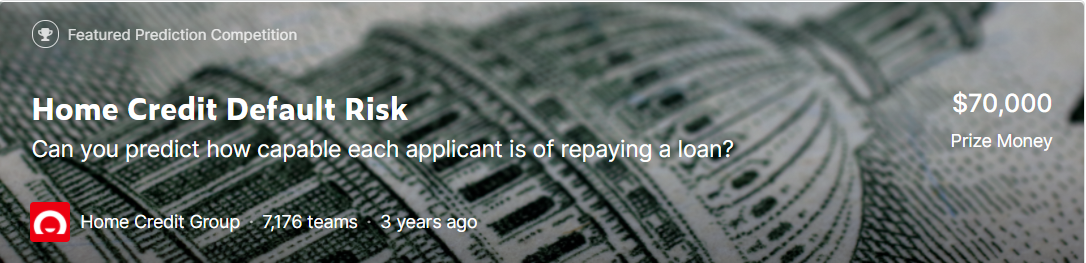


## Home Credit 대출 상환여부 예측
## 설명
- Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

- Home Credit Group

- Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

- While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

## 데이터 출처 : Kaggle 
- 링크 : https://www.kaggle.com/c/home-credit-default-risk

## Import

In [4]:
import pandas as pd
import numpy as np

## Load Data

In [5]:
from google.colab import files
uploaded = files.upload()

Saving loan_before.csv to loan_before (1).csv
Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
lb = pd.read_csv("loan_before.csv")
lb.columns

Index(['SK_ID_CURR', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'CREDIT_TYPE'],
      dtype='object')

# 1. 문제정의

<strong>질문 1</strong> - 어떤 요소가 대출금 상환 여부에 큰 영향을 줄까? <br>
<strong>질문 2</strong> - 그 요소들이 상환여부에 어떤 영향을 줄까?<br>

# 2. 방법론

## 2.1 분석과정(전처리)

이 질문에 대한 해답을 얻기 위해서 해석가능한 머신러닝(xAI)을 활용하였습니다.

<strong>프로세스</strong>

1단계 : feature engineering을 한다.<br>
2단계 : 머신러닝 모델을 만든다.<br>
3단계 : shap value를 통해 어떤 변수가 가장 큰 영향을 주는지 알아본다.<br>
4단계 : 영향을 많이 주는 5개의 변수와 대출금 상환 여부와의 관계를 살펴본다.

## 2.2 feature engineering

AMT_CREDIT에서 AMT_ANNUITY를 나누어 해당 사람이 몇개월에 걸쳐 돈을 갚아야 하는지 변수화하였다.

In [7]:
train['AMT_CREDIT_TO_ANNUITY_RATIO'] = train['AMT_CREDIT']/train['AMT_ANNUITY']
test['AMT_CREDIT_TO_ANNUITY_RATIO'] = test['AMT_CREDIT']/test['AMT_ANNUITY']

lb(이전에 대출한 정보가 기록된 데이터)를 활용해 변수생성을 시도한다.
<br>

<strong>1. groupby 후 평균(사람 id로 묶은 후 각 변수를 평균을 낸다)</strong><br>
<ul>
    <li>AMT_CREDIT_SUM(이전 대출의 금액)</li>
    <li>DAYS_CREDIT(train,test로부터 며칠 전에 이전 대출을 진행했는지)</li>
    <li>CNT_CREDIT_PROLONG(대출연장을 몇 번 했는지)</li>
</ul>
 
<strong>2. groupby 후 갯수(사람 id별로의 빈도수, 해당 사람이 이전에 대출을 몇 번 진행했는지)</strong>

In [8]:
train = pd.merge( train,lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(),on='SK_ID_CURR',how='left' )
test = pd.merge( test,lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(),on='SK_ID_CURR',how='left' )

train = pd.merge( train,lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(),on='SK_ID_CURR',how='left' )
test = pd.merge( test,lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(),on='SK_ID_CURR',how='left' )

train = pd.merge( train,lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(),on='SK_ID_CURR',how='left' )
test = pd.merge( test,lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(),on='SK_ID_CURR',how='left' )

In [9]:
train = pd.merge(train , lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0:'count'}),on='SK_ID_CURR', how='left')
test = pd.merge(test , lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0:'count'}),on='SK_ID_CURR', how='left')

해당 프로젝트의 목적은 모델 해석이기 때문에, 이에 방해를 주는 변수는 다 삭제한다.

<strong>제거한 변수목록</strong>
<ul>
    <li>CODE_GENDER : 범주형 변수</li>
    <li>FLAG_OWN_CAR : 범주형 변수</li>
    <li>NAME_TYPE_SUITE : 범주형 변수</li>
    <li>NAME_INCOME_TYPE : 범주형 변수</li>
    <li>NAME_EDUCATION_TYPE : 범주형 변수</li>
    <li>NAME_HOUSING_TYPE : 범주형 변수</li>
    <li>ORGANIZATION_TYPE : 범주형 변수</li>
    <li>EXT_SOURCE_1 : 변수의 의미를 정확히 모름</li>
    <li>EXT_SOURCE_2 : 변수의 의미를 정확히 모름</li>
    <li>EXT_SOURCE_3 : 변수의 의미를 정확히 모름</li>
</ul>

In [10]:
del_list = ['CODE_GENDER','FLAG_OWN_CAR','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE','ORGANIZATION_TYPE',
'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

In [11]:
train = train.drop(del_list,axis=1)
test = test.drop(del_list,axis=1)

In [12]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

## 2.3 모델링

<strong>모델링을 하기 전, 서로 상관관계가 높은 input 변수를 삭제한다.</strong>

이유 : input변수가 높은 상관성을 띌 때 shap value는 제대로 된 설명력을 발휘하지 못한다.

In [13]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

In [14]:
corr = train[input_var].corr()
corr.style.background_gradient(cmap='coolwarm')

,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
FLAG_OWN_REALTY,1.000000,0.008244,0.003243,-0.042446,-0.001448,0.010826,-0.110930,-0.015164,0.004217,0.019393,0.014595,-0.105580,0.026066,0.090058,-0.083920,-0.002745,0.000174,-0.009790,0.008414
CNT_CHILDREN,0.008244,1.000000,0.029879,0.006465,0.023275,-0.033326,0.332123,0.068807,-0.029581,-0.010951,0.883051,-0.009661,-0.006102,-0.036431,-0.022026,0.035864,0.026285,-0.012065,0.002649
AMT_INCOME_TOTAL,0.003243,0.029879,1.000000,0.366717,0.441573,0.185047,0.066875,-0.041696,0.029519,-0.126551,0.029342,0.092505,-0.040823,0.031593,0.077303,0.241929,-0.013266,0.016117,0.116635
AMT_CREDIT,-0.042446,0.006465,0.366717,1.000000,0.770938,0.092177,-0.047089,-0.085049,0.000988,-0.111244,0.066847,0.047472,-0.070924,-0.037907,0.656337,0.135435,-0.068411,-0.000384,0.046902
AMT_ANNUITY,-0.001448,0.023275,0.441573,0.770938,1.000000,0.127204,0.017106,-0.048381,0.013662,-0.108185,0.073912,0.047113,-0.058709,0.000270,0.111694,0.128144,-0.052613,-0.005724,0.013588
REGION_POPULATION_RELATIVE,0.010826,-0.033326,0.185047,0.092177,0.127204,1.000000,-0.023276,0.013870,0.000946,-0.088270,-0.025638,0.182730,-0.051167,0.015725,0.003524,0.077984,-0.010819,0.003701,-0.034289
DAYS_BIRTH,-0.110930,0.332123,0.066875,-0.047089,0.017106,-0.023276,1.000000,0.349373,0.266852,-0.015877,0.283729,0.087200,0.080317,-0.073904,-0.097736,0.053205,0.201829,0.028239,-0.063004
DAYS_EMPLOYED,-0.015164,0.068807,-0.041696,-0.085049,-0.048381,0.013870,0.349373,1.000000,0.093421,0.014016,0.032736,0.003502,0.144221,0.003833,-0.087176,-0.018131,0.160521,0.000124,-0.148704
DAYS_ID_PUBLISH,0.004217,-0.029581,0.029519,0.000988,0.013662,0.000946,0.266852,0.093421,1.000000,0.001141,-0.025311,0.029700,0.089952,-0.039895,-0.020280,0.033384,0.188471,0.022736,-0.100673
OWN_CAR_AGE,0.019393,-0.010951,-0.126551,-0.111244,-0.108185,-0.088270,-0.015877,0.014016,0.001141,1.000000,-0.039362,-0.082672,0.013561,-0.025423,-0.059224,-0.094781,-0.006665,0.011323,-0.025711


높은 상관성을 띄는 변수는 아래와 같다.
<ul>
    <li>CNT_FAM_MEMBERS , CNT_CHILDREN</li>
    <li>AMT_CREDIT_TO_ANNUITY_RATIO , AMT_CREDIT</li>
    <li>AMT_ANNUITY , AMT_CREDIT</li>
</ul>

CNT_FAM_MEMBERS와 CNT_CHILDREN 중 타겟값과 높은 결정계수를 가진 변수는 CNT_CHILDREN이므로, CNT_FAM_MEMBERS를 삭제한다.

In [15]:
print(train['CNT_FAM_MEMBERS'].corr(train['TARGET']))
print(train['CNT_CHILDREN'].corr(train['TARGET']))

0.018876651698723722
0.025357359317615673


In [16]:
del train['CNT_FAM_MEMBERS']
del test['CNT_FAM_MEMBERS']

AMT_CREDIT_TO_ANNUITY_RATIO와 AMT_CREDIT 중 타겟값과 높은 결정계수를 가진 변수는 AMT_CREDIT_TO_ANNUITY_RATIO이므로, AMT_CREDIT를 삭제한다.

In [17]:
print(train['AMT_CREDIT_TO_ANNUITY_RATIO'].corr(train['TARGET']))
print(train['AMT_CREDIT'].corr(train['TARGET']))

-0.02474028833519016
-0.022558430849347638


In [18]:
del train['AMT_CREDIT']
del test['AMT_CREDIT']

In [19]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

In [20]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

<strong>xgboost를 활용해 모델링을 진행한다.</strong>

이유 : shap value를 활용하기 위해선 모델이 랜덤포레스트 형태의 tree형 모델이어야 한다. 이 중에서 xgboost가 속도가 빠르면서 높은 성능을 유지하므로 이를 선택하였습니다.

In [21]:
from xgboost import XGBClassifier

In [22]:
model = XGBClassifier(n_estimators=100, learning_rate=0.1)
model.fit(train[input_var],train['TARGET'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## 2.4 shap value 활용

## * 부가설명 *
SHAP은 Shapley value를 기반으로 하는 방법이고 적은 수의 특성으로도 설명성을 나타낼 수 있다. Shapley value는 LIME과 다르게 설명가능한 모델이 아닌 단순히 특성별 기여도를 나타내는 값입니다.

In [23]:
! pip install shap

     |████████████████████████████████| 358kB 7.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491619 sha256=0ab65f357fe08b98bdafdeda507fc454f73292da0a1256ac8748166e403983d1
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [24]:
import shap

In [25]:
shap_values = shap.TreeExplainer(model).shap_values(train[input_var])

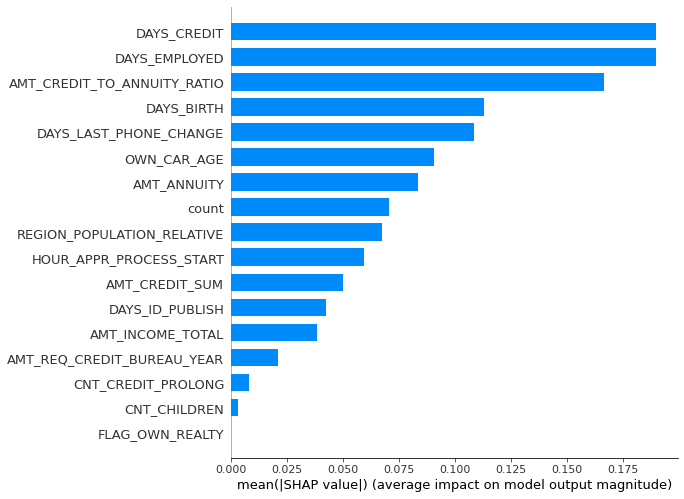

In [26]:
shap.summary_plot(shap_values, train[input_var], plot_type='bar')

시각화 결과, 타겟값에 가장 큰 영향을 미치는 상위 5가지 변수는 아래와 같습니다.

<ul>
    <li>AMT_CREDIT_TO_ANNUITY_RATIO</li>
    <li>DAYS_EMPLOYED</li>
    <li>DAYS_CREDIT</li>
    <li>DAYS_BIRTH</li>
    <li>DAYS_LAST_PHONE_CHANGE</li>
</ul>

## 2.5 영향을 많이 주는 5개의 변수와 상환 여부와의 관계를 파악한다.

1. AMT_CREDIT_TO_ANNUITY_RATIO

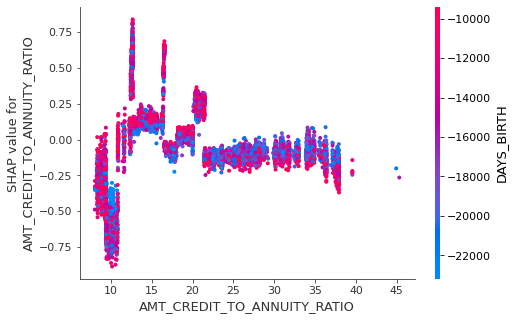

In [27]:
shap.dependence_plot('AMT_CREDIT_TO_ANNUITY_RATIO', shap_values, train[input_var])

대출 상환 기간이 12개월에서 20개월 사이일 때 비교적 상환을 잘 못한다.<br>
반면 12개월 이하, 20개월 이상일 때는 상환을 비교적 잘 한다.

2. DAYS_EMPLOYED

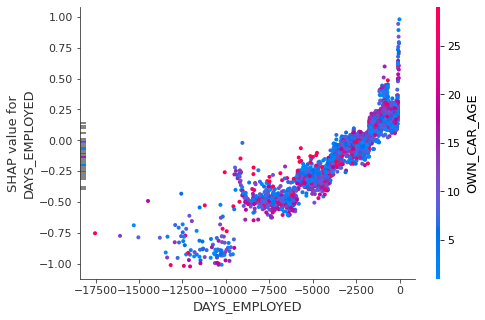

In [28]:
shap.dependence_plot('DAYS_EMPLOYED', shap_values, train[input_var])

취업한지 오래되면 오래될 수록 대출상환확률이 올라간다.<br>
대출일 기준 9000일보다 오래 전에 취업했을 때 대출상환능력이 급상승한다.

3. DAYS_CREDIT

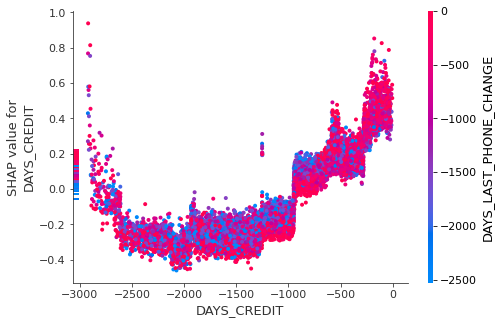

In [29]:
shap.dependence_plot('DAYS_CREDIT', shap_values, train[input_var])

DAYS_CREDIT은 -3000일부터 -2000일까지는 대출상환능력이 상승한다.<br>
그 이후부턴 하락한다.<br>

4. DAYS_BIRTH

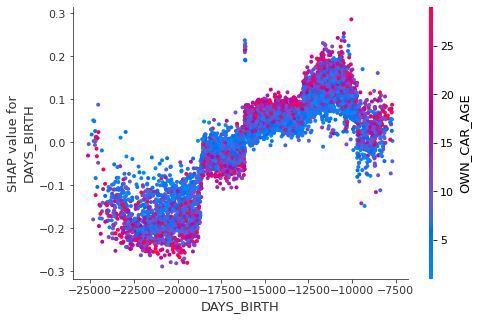

In [30]:
shap.dependence_plot('DAYS_BIRTH', shap_values, train[input_var])

나이가 많으면 많을수록 대출상환을 잘 하는 경향이 있다.

5. DAYS_LAST_PHONE_CHANGE

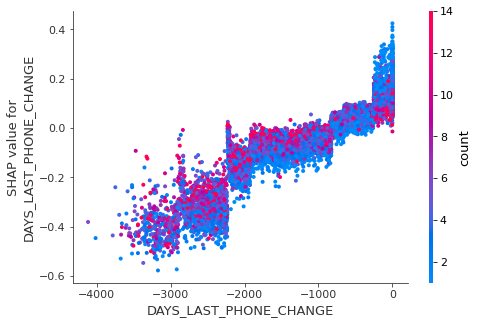

In [31]:
shap.dependence_plot('DAYS_LAST_PHONE_CHANGE', shap_values, train[input_var])

핸드폰을 오래전에 바꾸었을 수록 대출금을 상환할 가능성이 높아진다.

# 3. 결론


1. 대출 상환 기간이 상환여부에 가장 큰 영향을 준다. 해당 영향을 비선형적 관계입니다.

  (영향이 크다고 해서 인과관계가 있다고 단정짓긴 어렵습니다.)
<br><br>
2. 주택 보유 여부와 자식의 수는 대출 상환능력에 큰 영향을 미치지 않습니다.
<br><br>
3. 최근에 취업했을 수록, 최근에 대출을 받았을수록, 최근에 핸드폰을 바꿨을 수록, 나이가 어릴수록 대출금 상환 가능성이 낮은 지표를 보입니다.

  (추가적으로 DAYS_EMPLOYED, DAYS_CREDIT, DAYS_LAST_PHONE_CHANGE, DAYS_BIRTH 가 클수록 대출금 상환 가능성이 낮아지는 것을 확인할 수 있습니다.)<br>


## 3.1 마무리 시각화

In [32]:
train['DAYS_EMPLOYED'].quantile(0.75) < train['DAYS_EMPLOYED']

0        False
1        False
2        False
3        False
4        False
         ...  
19995    False
19996    False
19997     True
19998    False
19999    False
Name: DAYS_EMPLOYED, Length: 20000, dtype: bool

In [33]:
group1 = train.loc[ (train['DAYS_EMPLOYED'].quantile(0.75)< train['DAYS_EMPLOYED']) &
           (train['DAYS_CREDIT'].quantile(0.75)< train['DAYS_CREDIT']) &
           (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.75)< train['DAYS_LAST_PHONE_CHANGE']) &
           (train['DAYS_BIRTH'].quantile(0.75)< train['DAYS_BIRTH']) ]

In [34]:
group2 = train.loc[ (train['DAYS_EMPLOYED'].quantile(0.25)> train['DAYS_EMPLOYED']) &
           (train['DAYS_CREDIT'].quantile(0.25)> train['DAYS_CREDIT']) &
           (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.25)> train['DAYS_LAST_PHONE_CHANGE']) &
           (train['DAYS_BIRTH'].quantile(0.25)> train['DAYS_BIRTH']) ]

In [35]:
group1['group'] = 1
group2['group'] = 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
full = pd.concat([group1,group2],axis=0)

In [37]:
import seaborn as sns

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


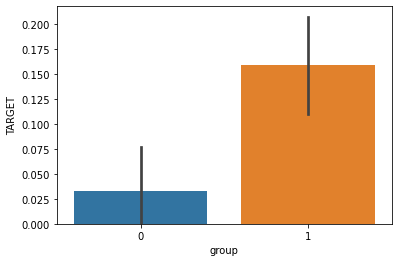

In [38]:
sns.barplot('group','TARGET',data=full)